# MACD

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:
from config.constants import *
from backtesting import Backtest
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from MACD import MACD
from util.Save_result_return import save_to_csv


## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [5]:
strategy = MACD

In [6]:
account_size = 20000

# Backtest each time frame

## TF D1

In [7]:
Backtest_D1 = Backtest(XAUUSD['D1'], strategy, cash=account_size, margin=1/2000, )
result_D1 = Backtest_D1.run()
result_D1

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   99.325798
Equity Final [$]                    20316.018
Equity Peak [$]                     20753.513
Return [%]                            1.58009
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.078371
Volatility (Ann.) [%]                1.031227
Sharpe Ratio                         0.075998
Sortino Ratio                        0.108589
Calmar Ratio                         0.017928
Max. Drawdown [%]                   -4.371429
Avg. Drawdown [%]                   -0.483469
Max. Drawdown Duration     1880 days 00:00:00
Avg. Drawdown Duration      154 days 00:00:00
# Trades                                  399
Win Rate [%]                        34.085213
Best Trade [%]                      14.333636
Worst Trade [%]                     -9.045791
Avg. Trade [%]                    

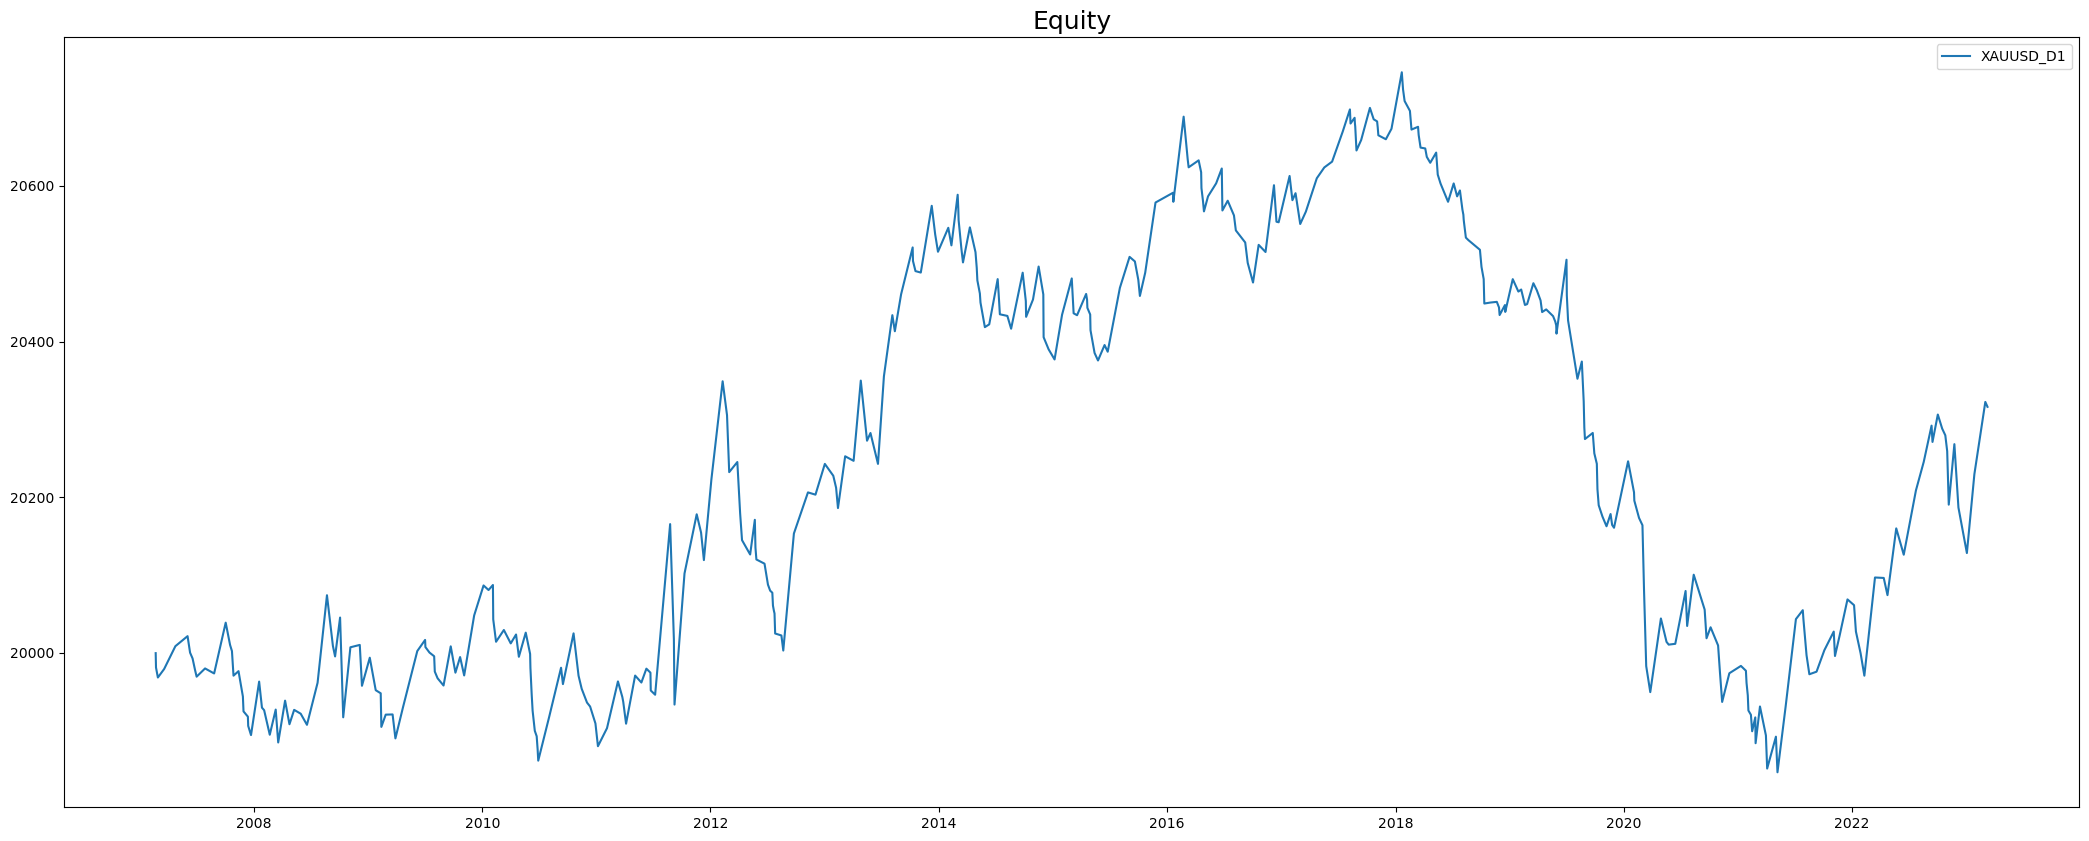

In [8]:
plot_equity_trades(result_D1['_trades'],'XAUUSD_D1' , account_size)

### Save output

In [9]:
# save_to_csv(result_D1, '../../out/Technical_Strategy/MACD/Backtest/result_D1.csv')  

## TF H4

In [10]:
Backtest_H4 = Backtest(XAUUSD['H4'], strategy,
                       cash=account_size, margin=1/2000, )
result_H4 = Backtest_H4.run()
result_H4

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                    99.86911
Equity Final [$]                    22145.365
Equity Peak [$]                     22515.466
Return [%]                          10.726825
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                    0.510475
Volatility (Ann.) [%]                0.971367
Sharpe Ratio                         0.525523
Sortino Ratio                        0.797681
Calmar Ratio                         0.222186
Max. Drawdown [%]                   -2.297516
Avg. Drawdown [%]                   -0.134007
Max. Drawdown Duration     2021 days 20:00:00
Avg. Drawdown Duration       22 days 14:00:00
# Trades                                 1974
Win Rate [%]                        37.740628
Best Trade [%]                      11.531394
Worst Trade [%]                     -5.458385
Avg. Trade [%]                    

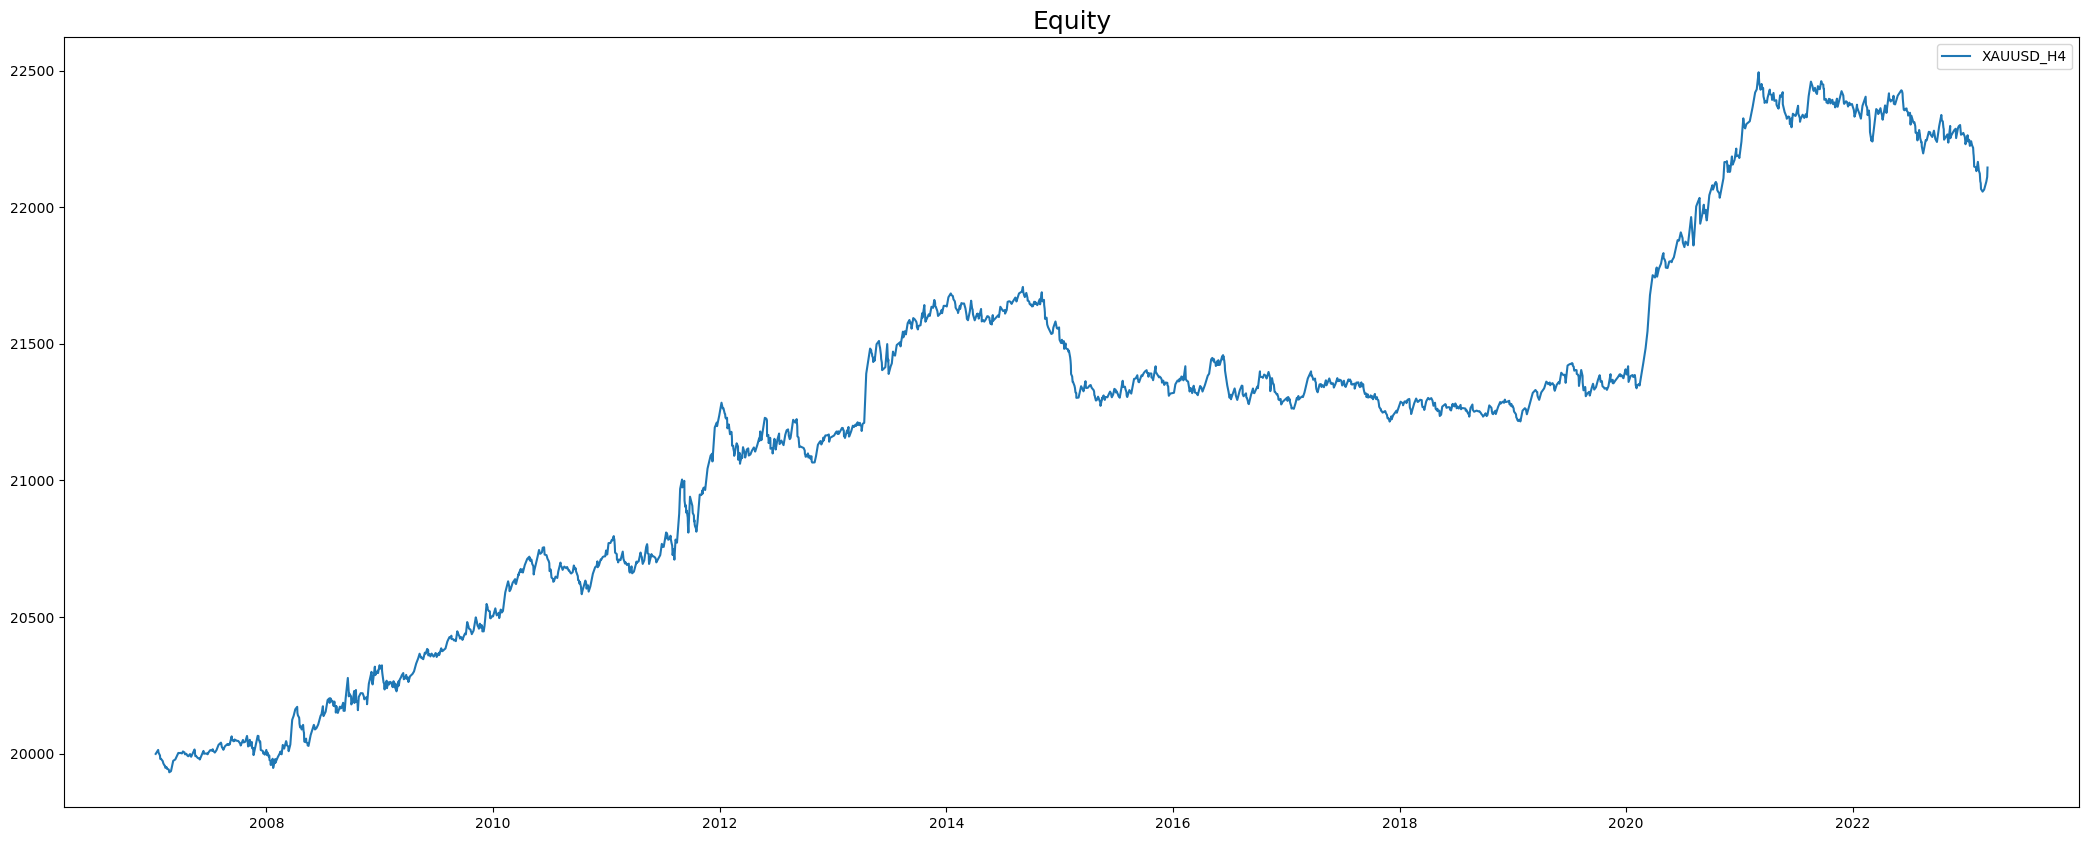

In [11]:
plot_equity_trades(result_H4['_trades'], 'XAUUSD_H4' , account_size)

### Save output

In [12]:
# save_to_csv(result_H4, '../../out/Technical_Strategy/MACD//Backtest/result_H4.csv')  

## TF H1

In [13]:
Backtest_H1 = Backtest(XAUUSD['H1'], strategy,
                       cash=account_size, margin=1/2000, )
result_H1 = Backtest_H1.run()
result_H1

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                    99.96529
Equity Final [$]                    21436.032
Equity Peak [$]                      21543.42
Return [%]                            7.18016
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                      0.3471
Volatility (Ann.) [%]                0.982935
Sharpe Ratio                         0.353126
Sortino Ratio                        0.530263
Calmar Ratio                         0.082096
Max. Drawdown [%]                    -4.22799
Avg. Drawdown [%]                   -0.089481
Max. Drawdown Duration     1488 days 22:00:00
Avg. Drawdown Duration       17 days 15:00:00
# Trades                                 7515
Win Rate [%]                        35.143047
Best Trade [%]                      13.198196
Worst Trade [%]                     -5.141061
Avg. Trade [%]                    

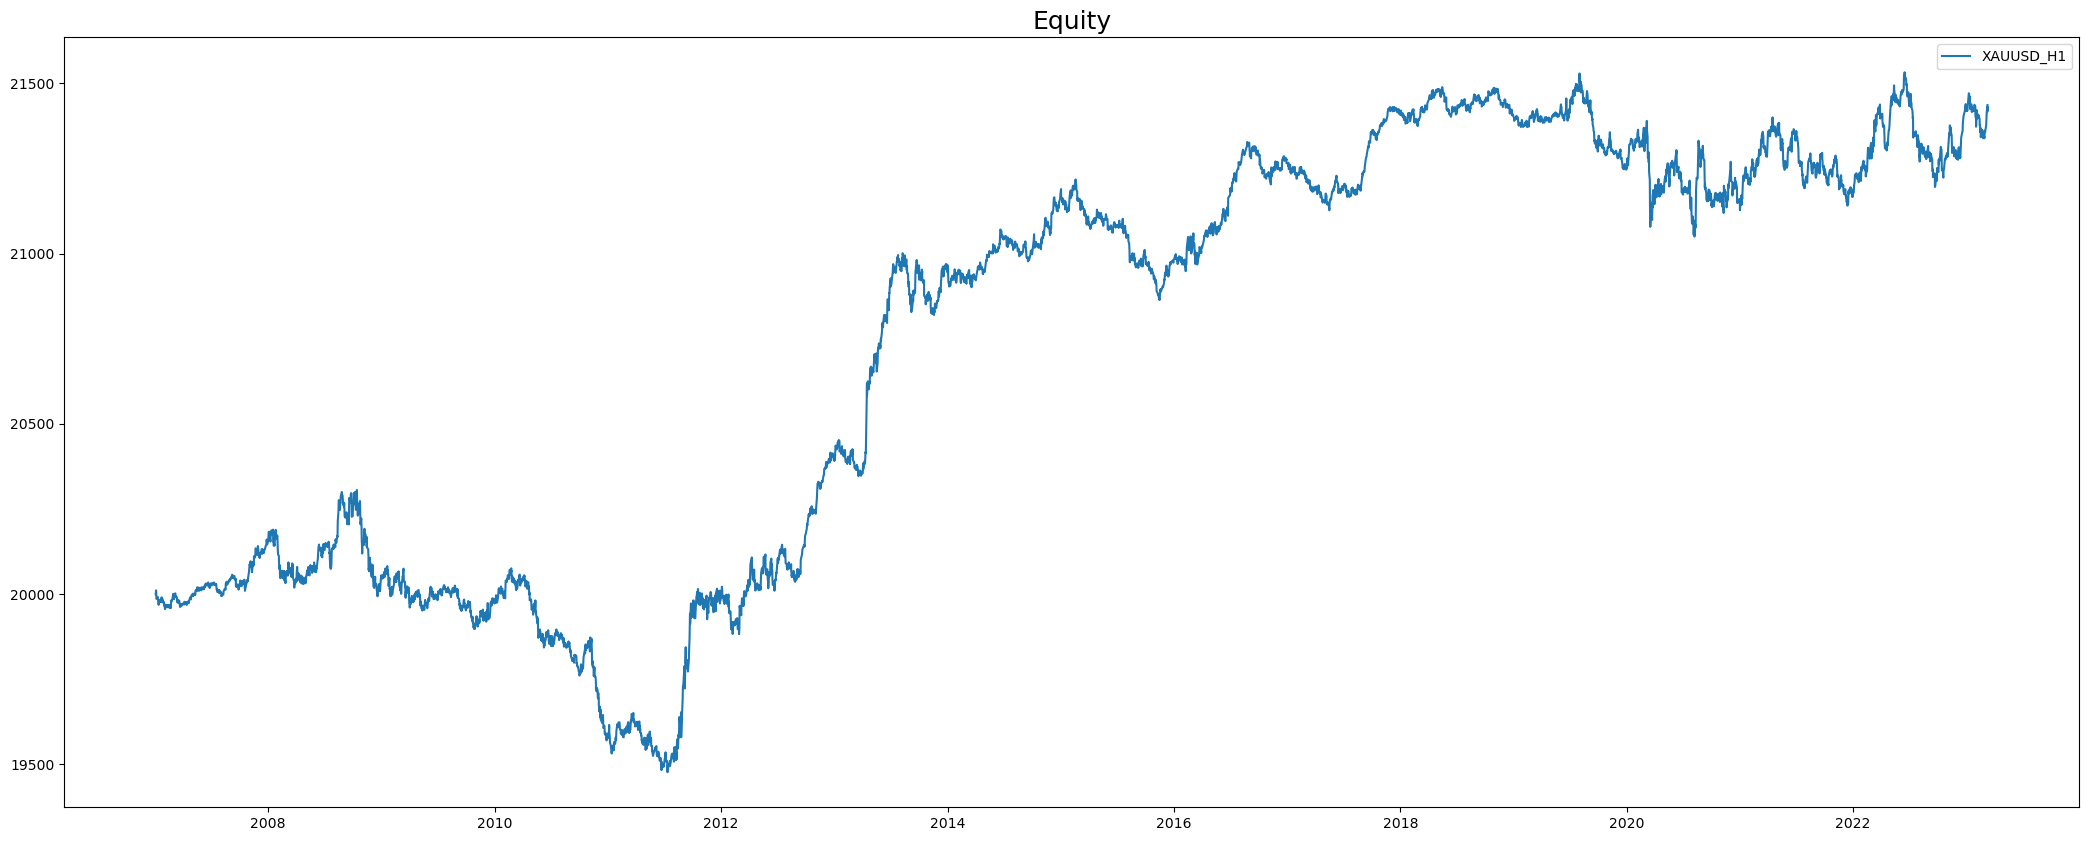

In [14]:
plot_equity_trades(result_H1['_trades'], 'XAUUSD_H1', account_size)

### Save output

In [16]:
# save_to_csv(result_H1, '../../out/Technical_Strategy/MACD/Backtest/result_H1.csv')  

## TF M30 

In [7]:
Backtest_M30 = Backtest(XAUUSD['M30'], strategy,
                       cash=account_size, margin=1/2000, )
result_M30 = Backtest_M30.run()
result_M30

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   99.982585
Equity Final [$]                    18476.796
Equity Peak [$]                     20114.654
Return [%]                           -7.61602
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                   -0.395359
Volatility (Ann.) [%]                1.110787
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -10.368416
Avg. Drawdown [%]                   -0.180178
Max. Drawdown Duration     5545 days 15:30:00
Avg. Drawdown Duration       85 days 16:01:00
# Trades                                14965
Win Rate [%]                        33.558303
Best Trade [%]                       8.766291
Worst Trade [%]                     -4.156549
Avg. Trade [%]                    

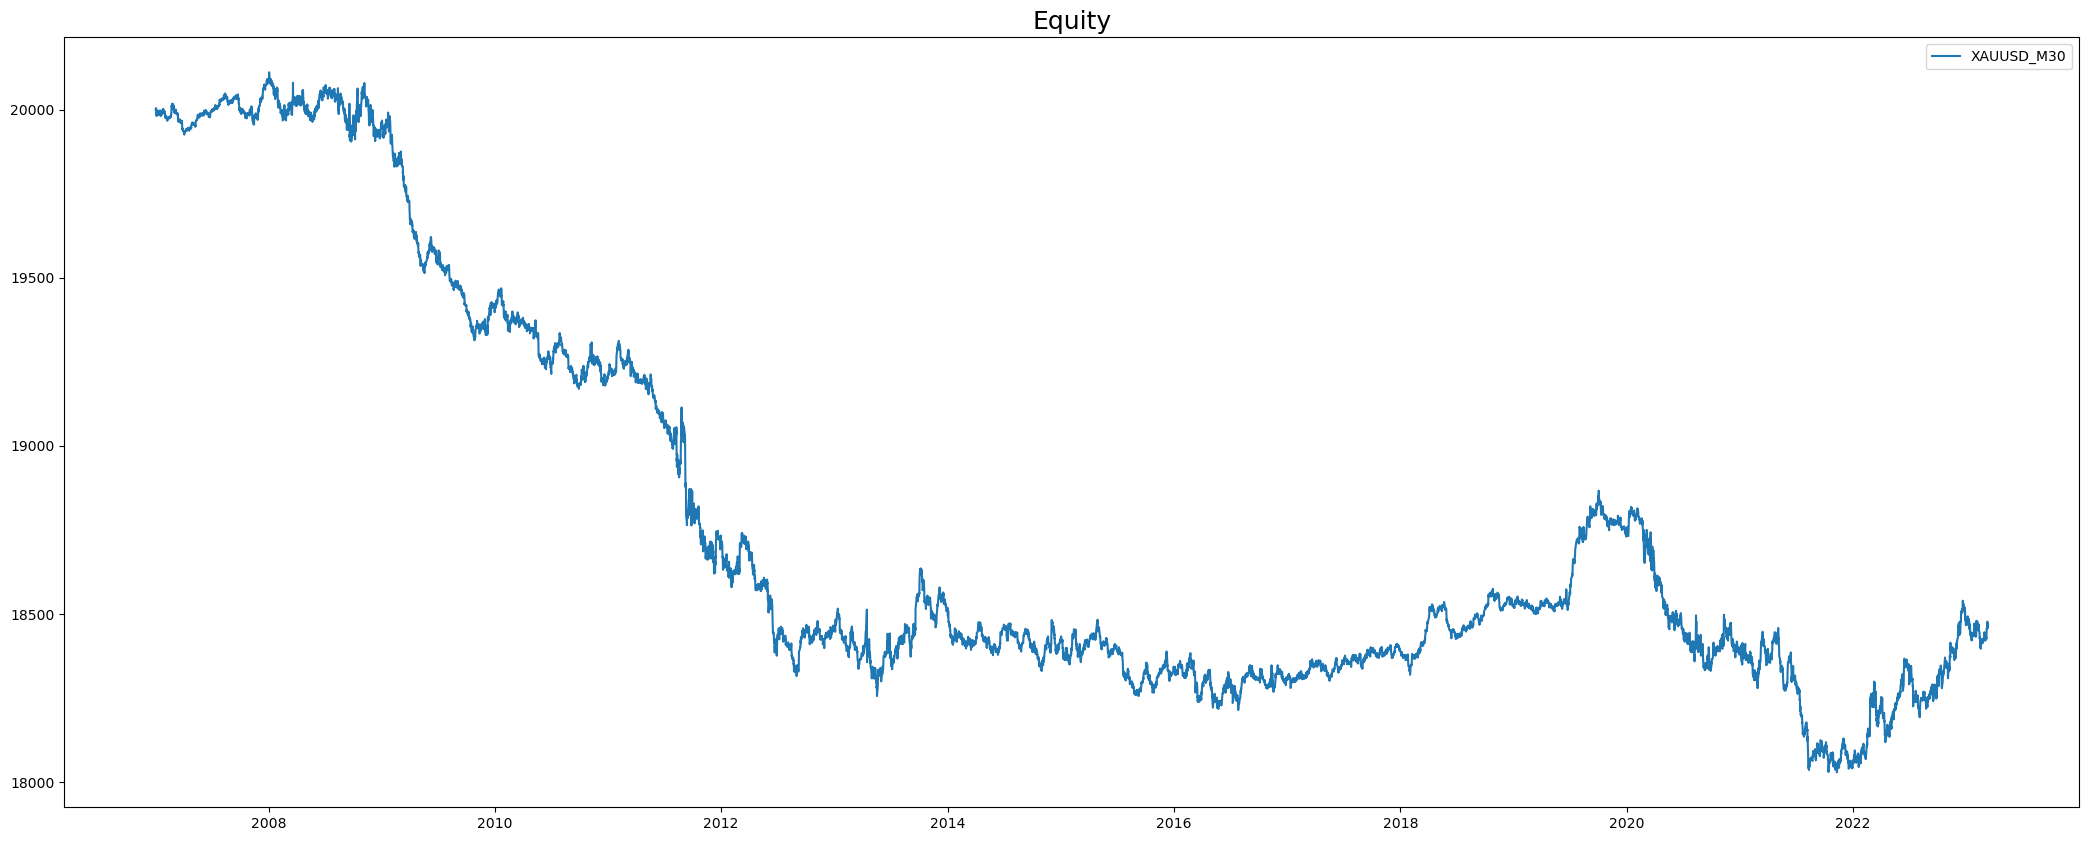

In [8]:
plot_equity_trades(result_M30['_trades'], 'XAUUSD_M30', account_size)

### Save output

In [9]:
# save_to_csv(result_M30, '../../out/Technical_Strategy/MACD/Backtest/result_M30.csv')  